You are supposed to train and apply a boosting model for landcover classification. Below, you can find some code that already parses the data. For your submission, run and submit the extended jupyter notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier


In [2]:
# load data
train = np.load("./train.npz")
X_train = train["X"]
y_train = train["y"].reshape((-1, 1))

test = np.load("./test.npz")
X_test = test["X"]
y_test = test["y"].reshape((-1, 1))

classes = {
    1: "cultivated_land",
    2: "forest",
    3: "grassland",
    4: "shrubland",
    5: "water",
    8: "artificial_surface",
    9: "bareland",
}


In [3]:
print("Shape of training data: {}".format(X_train.shape))
print("Shape of training labels: {}".format(y_train.shape))
print("Shape of test data: {}".format(X_test.shape))
print("Shape of test labels: {}".format(y_test.shape))

Shape of training data: (6953, 12, 13, 13, 6)
Shape of training labels: (6953, 1)
Shape of test data: (1739, 12, 13, 13, 6)
Shape of test labels: (1739, 1)


The training and test set contain a few thousand instances. Each instance is based on image of size 13x13 pixels, which are available for 12 timestamps and 6 bands. That is, one is given an array of shape (12,13,13,6) for each instance. The label arrays contain the labels associated with the instances, where the central pixel/position determines the class of the (whole) image array for each instance, see below.

In [4]:
# # visualize some of the (image) data


# idx = 0

# print(
#     "Label (i.e., class of pixel in the center of the images) for image sequence: {}".format(
#         classes[y_train[idx, 0]]
#     )
# )

# for year in range(12):
#     fig, axs = plt.subplots(1, 6, figsize=(24, 4))
#     for b in range(6):
#         axs[b].imshow(X_train[idx, year, :, :, b], cmap=plt.get_cmap("Greys"))
#         axs[b].set_title("Band {}".format(b + 1))


In [5]:
# ------------------------------------------------------------
# 0.  Load the data (cell already provided by the exercise)
# ------------------------------------------------------------


# ------- helper: stack the 72 features of the centre pixel -------
def central_pixel_only(X4d):
    # X4d … shape (n, 12, 13, 13, 6)
    centre = X4d[:, :, 6, 6, :]  # -> (n, 12, 6)
    return centre.reshape(len(X4d), -1)  # -> (n, 72)


def window_pixel_only(X4d):
    # X4d … shape (n, 12, 13, 13, 6)
    # 1. Select 3x3 window around the center pixel
    window = X4d[:, :, 4:9, 4:9, :]  # Shape: (n, 12, 3, 3, 6)

    # 2. Calculate the mean over the 3x3 spatial window for each band and timestamp
    spatial_mean_at_each_timestamp = np.mean(window, axis=(2, 3))  # Shape: (n, 12, 6)

    # 3. Pick one temporal statistic: calculate the mean *over time* for each band
    temporal_mean_per_band = np.mean(
        spatial_mean_at_each_timestamp, axis=1, keepdims=True
    )  # Shape: (n, 1, 6)

    # 4. Tile this single temporal statistic back across the 12 timestamps
    expanded_temporal_statistic = np.tile(
        temporal_mean_per_band, (1, 12, 1)
    )  # Shape: (n, 12, 6)

    # 5. Reshape to (n, 72) by flattening the 12 timestamps and 6 bands
    return spatial_mean_at_each_timestamp.reshape(len(X4d), -1)  # Shape: (n, 72)


Xtr_c = central_pixel_only(X_train)  # Changed to use window_pixel_only
Xte_c = central_pixel_only(X_test)  # Changed to use window_pixel_only
ytr = y_train.ravel()
yte = y_test.ravel()

scaler = StandardScaler()
Xtr_c_scaled = scaler.fit_transform(Xtr_c)
Xte_c_scaled = scaler.transform(Xte_c)  # Apply the same transformation to test data


In [6]:
Xtr_c_scaled.shape, Xte_c_scaled.shape, ytr.shape, yte.shape

((6953, 72), (1739, 72), (6953,), (1739,))

In [7]:
# # Examine the central pixel features used for training
# print("Central pixel features shape:", Xtr_c.shape)
# print("\nCentral pixel feature statistics:")
# print(f"Min value: {Xtr_c.min():.4f}")
# print(f"Max value: {Xtr_c.max():.4f}")
# print(f"Mean value: {Xtr_c.mean():.4f}")
# print(f"Std deviation: {Xtr_c.std():.4f}")

# # Check feature statistics across the 72 features (12 timestamps × 6 bands)
# print("\nFeature statistics (across all samples):")
# print(
#     f"Feature means range: {Xtr_c.mean(axis=0).min():.4f} to {Xtr_c.mean(axis=0).max():.4f}"
# )
# print(
#     f"Feature stds range: {Xtr_c.std(axis=0).min():.4f} to {Xtr_c.std(axis=0).max():.4f}"
# )

# # Visualize feature distributions

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# # Plot histogram of all feature values
# ax1.hist(Xtr_c.flatten(), bins=50, alpha=0.7, edgecolor="black")
# ax1.set_xlabel("Pixel Value")
# ax1.set_ylabel("Frequency")
# ax1.set_title("Distribution of All Central Pixel Values")
# ax1.grid(True, alpha=0.3)

# # Plot feature means and stds
# feature_means = Xtr_c.mean(axis=0)
# feature_stds = Xtr_c.std(axis=0)

# ax2.scatter(feature_means, feature_stds, alpha=0.6)
# ax2.set_xlabel("Feature Mean")
# ax2.set_ylabel("Feature Std")
# ax2.set_title("Feature Means vs Standard Deviations")
# ax2.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

In [8]:
# ------------------------------------------------------------
# 1.  Grid-search (2-fold stratified CV)
# ------------------------------------------------------------
base_est = DecisionTreeClassifier(criterion="gini", random_state=0)

ada = AdaBoostClassifier(
    estimator=base_est,
    random_state=0,
)

param_grid = {
    "estimator__max_depth": [1, 2, 3],  # , 4, 5, 7],
    "n_estimators": [50, 100, 200],  # , 300, 400, 500, 600],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

search = GridSearchCV(ada, param_grid, cv=cv, scoring="accuracy", n_jobs=-1, verbose=1)
search.fit(Xtr_c_scaled, ytr)

print("Best parameters :", search.best_params_)
print("CV accuracy      : %.4f" % search.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


Best parameters : {'estimator__max_depth': 3, 'n_estimators': 100}
CV accuracy      : 0.7536


In [9]:
best_model = search.best_estimator_
best_model.fit(Xtr_c_scaled, ytr)

y_pred = best_model.predict(Xte_c_scaled)
acc = accuracy_score(yte, y_pred)
print("TEST accuracy : %.4f" % acc)


TEST accuracy : 0.7194


In [10]:
# # instantiate the base model
# base_model = DecisionTreeClassifier(criterion="gini", random_state=0, max_depth=3)

# # instantiate the AdaBoost model
# model = AdaBoostClassifier(estimator=base_model, n_estimators=200)

# # fit the model
# model.fit(Xtr_c_scaled, ytr)

# y_pred = model.predict(Xte_c_scaled)
# acc = accuracy_score(yte, y_pred)
# print("TEST accuracy : %.4f" % acc)

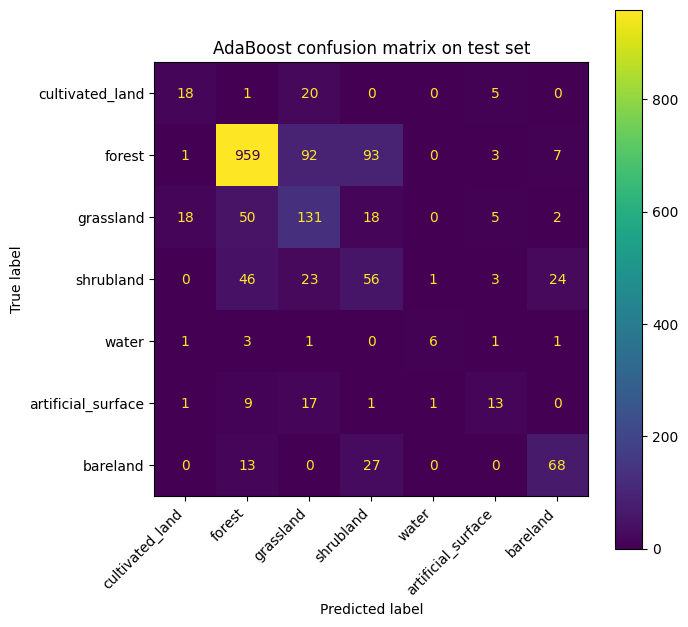

In [11]:
cm = confusion_matrix(yte, y_pred, labels=list(classes.keys()))
disp = ConfusionMatrixDisplay(cm, display_labels=list(classes.values()))

# Create a figure and an axes for plotting
fig, ax = plt.subplots(figsize=(7, 7))

# Plot the confusion matrix
disp.plot(ax=ax)

# Rotate x-axis labels
plt.xticks(rotation=45, ha="right")

# Set the title for the plot
ax.set_title("AdaBoost confusion matrix on test set")

plt.show()